In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import clear_output
import IPython.display as ipd
import librosa
import time as time
import os

import ruptures as rpt

from chord_prediction import RootCNN, ChordCNN, predict

In [3]:
# Global
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sr = 44100  
device_index = 1  
# print(sd.query_devices())

# Root
root_model = RootCNN()
root_model.load_state_dict(torch.load('rootcqtcnn_asim1_1005.pth', map_location=device))
root_model.eval()

# Chord
chord_model = ChordCNN()
chord_model.load_state_dict(torch.load('chordcqtcnn_asim1_0905.pth', map_location=device))
chord_model.eval()
clear_output(wait=True)


Single Chord

Recording finished.


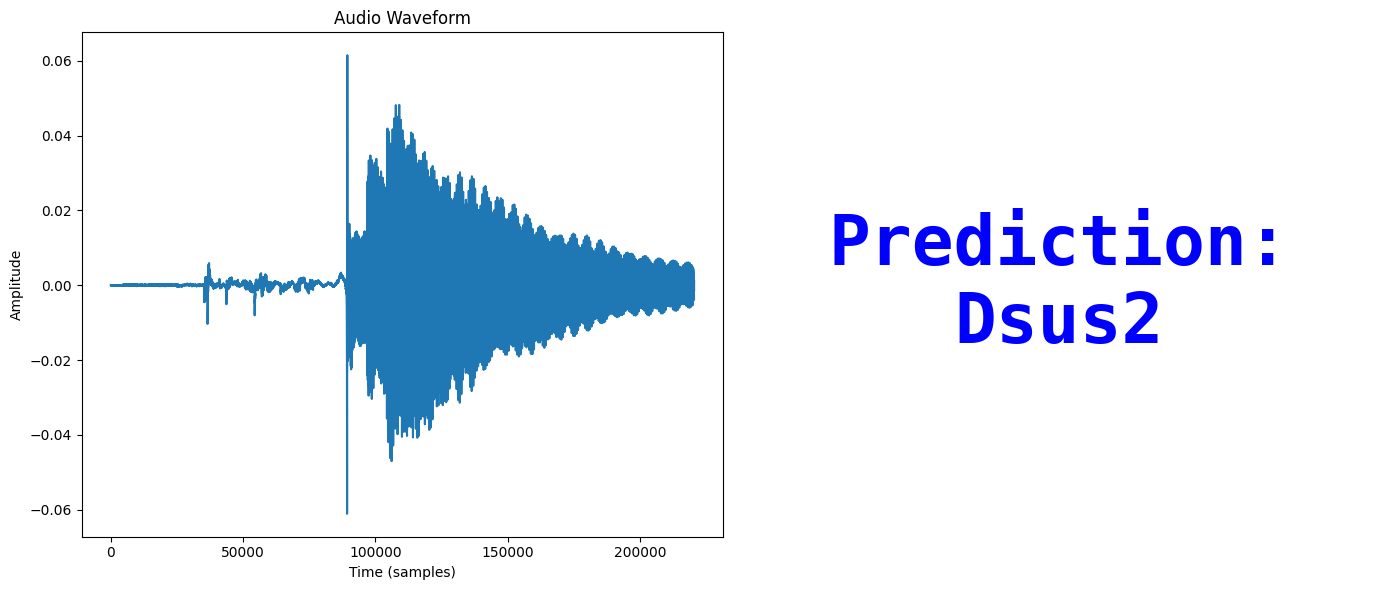

In [57]:
# Record audio 
print("Recording...")

audio_data = sd.rec(int(sr * 5),
                    samplerate=sr,
                    channels=1,
                    dtype='float32',
                    device=device_index)

sd.wait()  # Wait for the recording to finish

clear_output(wait=True)
print("Recording finished.")

audio_data = audio_data.flatten()
result = predict(audio_data, root_model, chord_model)

# Rseult Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(audio_data)
ax1.set_title('Audio Waveform')
ax1.set_xlabel('Time (samples)')
ax1.set_ylabel('Amplitude')

ax2.text(0.5, 0.5, f'Prediction:\n{result}',
         fontsize=50, ha='center', va='center',
         color='blue', fontweight='bold', family='monospace')
ax2.axis('off')  # Optional: hide axes in the text plot

plt.tight_layout()  # Adjust spacing
plt.show()

# user_label = input("Enter chord label:")

# # Save audio 
# dataset_dir = 'Guitar/'

# filename = f"{user_label}_{int(time.time())}.wav"
# filepath = os.path.join(dataset_dir, filename)
# sf.write(filepath, audio_data, sample_rate)

# print(f"Audio saved to {filepath}")
# ipd.Audio(audio_data, rate=sample_rate)

Multi Chord

In [7]:
# Record audio 
print("Recording...")

criteria = "tempo"
# criteria = "cosdif"
max_length = 5

audio_data = sd.rec(int(sr * 15),
                    samplerate=sr,
                    channels=1,
                    dtype='float32',
                    device=device_index)
sd.wait()

clear_output(wait=True)
print("Recording finished.")

audio_data = audio_data.flatten()
harm, perc = librosa.effects.hpss(audio_data)

if criteria == "cosdif":
    cqt = librosa.cqt(y=harm, sr=sr, n_bins=84, bins_per_octave=12)
    cqt = librosa.amplitude_to_db(abs(cqt))
    cqt = (cqt - np.mean(cqt)) / (np.std(cqt) + 1e-8)

    cqt_smooth = librosa.decompose.nn_filter(cqt, aggregate=np.median, metric='cosine')

    cpd = rpt.Pelt(model="rbf").fit(cqt_smooth.T) # Change-Point Detection
    breakpoints = cpd.predict(pen=10)  # Ajustar 

    frame_times = librosa.frames_to_time(np.arange(cqt.shape[1]), sr=sr, hop_length=512)
    output_onsets = librosa.frames_to_time(breakpoints[:-1], sr=sr, hop_length=512)

elif criteria == "tempo":
    tempo, beat_frames = librosa.beat.beat_track(y=perc, sr=sr, tightness=150) #, trim=False, tightness=100, units='frames')
    print(tempo)

    if tempo > 110: output_onsets = librosa.frames_to_time(beat_frames[::2], sr=sr)
    else: output_onsets = librosa.frames_to_time(beat_frames, sr=sr)

final_onsets = np.unique(np.concatenate(([0.0], np.array(output_onsets), [np.floor(len(audio_data)/sr)])))

chord_predictions = []

for i in range(len(final_onsets) - 1):

    start, end = int(final_onsets[i] * sr), int(final_onsets[i+1] * sr)
    window = audio_data[start:end]

    prediction, root, chord = predict(window, root_model, chord_model)
    chord_predictions.append(prediction)

clear_output(wait=True)

min_duration = 0.5
durations = np.diff(final_onsets)
mask = durations > min_duration

# Apply mask to both onset intervals and predictions
filtered_onsets = final_onsets[:-1][mask]
filtered_preds = [chord_predictions[i] for i, keep in enumerate(mask) if keep]

# Add last onset for display alignment
filtered_onsets = np.append(filtered_onsets, final_onsets[-1])
    
for i in range(len(filtered_preds)):
    print(f"{filtered_onsets[i]:.2f} - {filtered_preds[i]}")
    

0.00 - NC
1.38 - B
2.01 - B
2.64 - B
3.25 - Bm
3.88 - G#m
4.53 - G#m
5.17 - G#m
5.82 - G#m
6.49 - C#5
7.15 - C#m
7.84 - C#m
8.49 - C#m7
9.14 - F#
9.81 - F#
10.51 - F#7
11.19 - F#7
11.87 - B


In [8]:
clicks = librosa.clicks(times=final_onsets, sr=sr, length=len(audio_data))
ipd.Audio(audio_data + clicks, rate=sr)